In [ ]:
#Imports
import re
import tweepy
import configparser
import nltk
import string 
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

2022-09-15 03:50:14.097297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 03:50:14.219667: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-15 03:50:14.232683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 03:50:14.232703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# Laboratorio 6 - Análisis de redes sociales

## Configuración API

In [ ]:
#Configurando twitter API
config = configparser.ConfigParser()
config.read('config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [ ]:
#Obteniendo tweets y creando archivo
keyword = 'iOS 16 -filter:retweets'
limit = 3250

tweets = tweepy.Cursor(api.search_tweets, q=keyword, count=100, tweet_mode = 'extended', lang='en').items(limit)

columns = ['Time', 'User', 'Tweet']
data = []
for tweet in tweets:
    data.append([tweet.created_at, tweet.user.screen_name, tweet.full_text])

df = pd.DataFrame(data, columns = columns)
df.to_csv('tweets.csv')

## Análisis Exploratorio

In [ ]:
df['Tweet'].head()

0    that’s why I love twitter \nI only leaned the ...
1    @Barnacules @prettyph3nom I’d point you to htt...
2                        What that ios 16 talking bout
3    iOS 16 requires Face ID or your passcode for y...
4                                I love iOS 16 😭😍😍😍😍😍😍
Name: Tweet, dtype: object

In [ ]:
df.isna().sum()

Time     0
User     0
Tweet    0
dtype: int64

In [ ]:
count_apple = 0
count_android = 0
for tweet in df['Tweet']:
    tweet = tweet.lower()
    if 'apple' in tweet:
        count_apple+=1
    if 'android' in tweet:
        count_android+=1

print("Menciones a la empresa de Apple:", count_apple);
print("Menciones a android:", count_android)

Menciones a la empresa de Apple: 366
Menciones a android: 33


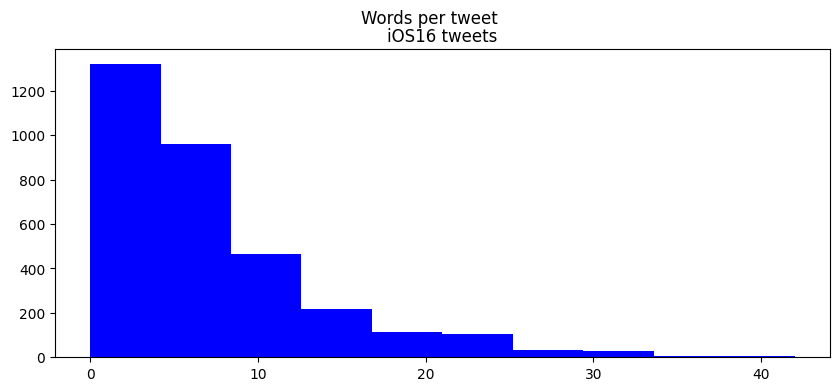

In [ ]:
df['word_count'] = df['Tweet'].apply(lambda x: len(str(x).split()))

fig,(ax1)=plt.subplots(1,figsize=(10,4))
train_words=df['word_count']
ax1.hist(train_words,color='blue')
ax1.set_title('iOS16 tweets')
fig.suptitle('Words per tweet')
plt.show()

## Limpieza de datos

In [ ]:
df = df.dropna()
df = df.drop_duplicates()

In [ ]:
punct = set(string.punctuation) 

def preprocess_tweet(row):
    text = row['Tweet']
    #Removing unicodes
    text = text.encode(encoding="ascii", errors="ignore")
    text = text.decode()
    text = " ".join([word for word in text.split()])
    #Removing URLs, Hashtags, Punctuation, Mentions, etc.
    text = re.sub("@\S+", "", text)
    text = re.sub("\$", "", text)
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)
    text = re.sub("#", "", text)
    text = "".join([ch for ch in text if ch not in punct])
    text = ''.join([i for i in text if not i.isdigit()])
    return text
    
df['Tweet'] = df.apply(preprocess_tweet, axis=1)

In [ ]:
#Remover espacios, puntuación convertir a minuscula de la columna text
df['Tweet'] = df['Tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

/tmp/ipykernel_1450/633880271.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Tweet'] = df['Tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess_stop_words(row):
    text = row['Tweet']
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    filtered_sentence = ' '.join((str(n) for n in filtered_sentence))
    return filtered_sentence
    
df['Tweet'] = df.apply(preprocess_stop_words, axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Pasar los verbos a singular y generalizarlos (ej: wrecked -> wreck)

nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_stemming_lemmatization(row):
    text = row['Tweet']
    temp = text.split()
    for w in range(len(temp)):
        temp[w] = lemmatizer.lemmatize(temp[w])
        temp[w] = stemmer.stem(temp[w])
        
    text = ' '.join((str(n) for n in temp))
    return text

df['Tweet'] = df.apply(preprocess_stemming_lemmatization, axis=1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df.head()

,Time,User,Tweet
0,2022-09-15 03:49:53+00:00,mathpurry,that love twitter lean io tool bc pure soul ma...
1,2022-09-15 03:49:49+00:00,Macintosh_Geek,id point
2,2022-09-15 03:49:41+00:00,_Kanzki,io talk bout
3,2022-09-15 03:49:39+00:00,KakamaRodney,io requir face id passcod hidden photo updat c...
4,2022-09-15 03:49:35+00:00,thascorpioo,love io


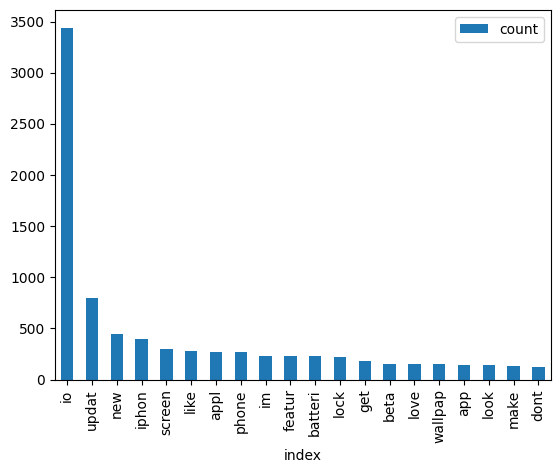

In [ ]:
#Frecuencia de palabras más mencionadas.
desdf = pd.DataFrame(df['Tweet'].str.split(expand=True).stack().value_counts().nlargest(20), columns=['count'])
ax = desdf.reset_index().plot.bar(x='index', y='count');

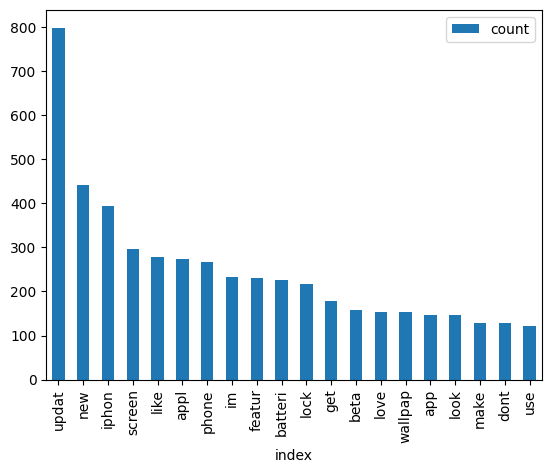

In [ ]:
#Frecuencia de palabras más mencionada sin io
df['Tweet'] = df['Tweet'].str.replace('io','')
desdf = pd.DataFrame(df['Tweet'].str.split(expand=True).stack().value_counts().nlargest(20), columns=['count'])
ax = desdf.reset_index().plot.bar(x='index', y='count');

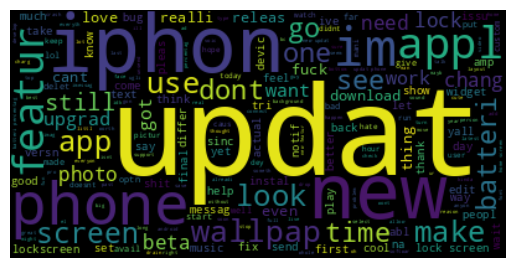

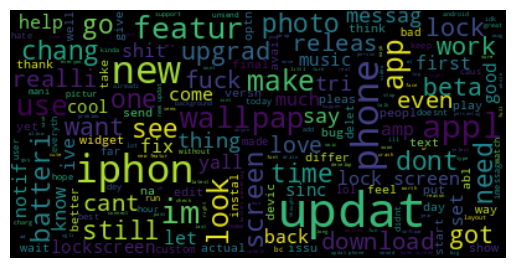

In [ ]:
#ngramas de tweets metaforicos
stoplist = stopwords.words('english') + ['though']
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(df['Tweet']) #Sean metaforicos
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram_meta = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_ngram_meta

# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(df_ngram_meta['bigram/trigram']))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(' '.join(df_ngram_meta['bigram/trigram']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
def sentiment_analyse_neg(sentiment_text):
    sentiment_text = sentiment_text['Tweet']
    score = SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    return score['neg']

def sentiment_analyse_pos(sentiment_text):
    sentiment_text = sentiment_text['Tweet']
    score = SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    return score['pos']

In [ ]:
df['negatividad'] = df.apply(sentiment_analyse_neg, axis=1)
df['positividad'] = df.apply(sentiment_analyse_pos, axis=1)

In [ ]:
df.head()

,Time,User,Tweet,negatividad,positividad
0,2022-09-15 03:49:53+00:00,mathpurry,that love twitter lean tool bc pure soul made...,0.000,0.421
1,2022-09-15 03:49:49+00:00,Macintosh_Geek,id point,0.000,0.000
2,2022-09-15 03:49:41+00:00,_Kanzki,talk bout,0.000,0.000
3,2022-09-15 03:49:39+00:00,KakamaRodney,requir face id passcod hidden photo updat can...,0.391,0.000
4,2022-09-15 03:49:35+00:00,thascorpioo,love,0.000,1.000


<AxesSubplot:>

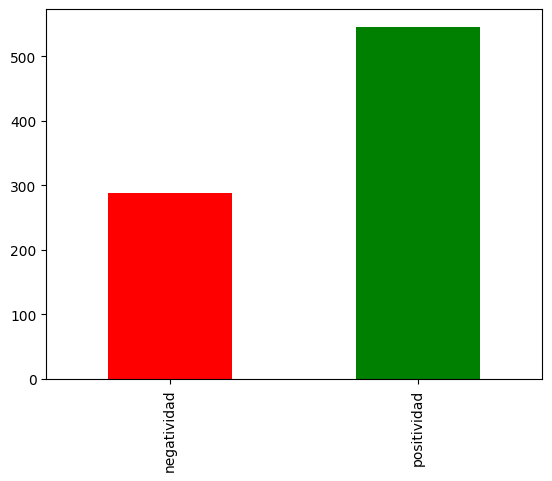

In [ ]:
df[['negatividad','positividad']].sum().plot.bar(color=['red', 'green'])

In [ ]:
df.nlargest(10, 'negatividad')

,Time,User,Tweet,negatividad,positividad
5,2022-09-15 03:49:30+00:00,ksleezzyyy,cheater,1.0,0.0
16,2022-09-15 03:46:52+00:00,h6micide,wtf shit,1.0,0.0
65,2022-09-15 03:39:06+00:00,roseisagoblin,fuck,1.0,0.0
122,2022-09-15 03:31:22+00:00,headfullofyves,damn,1.0,0.0
183,2022-09-15 03:22:52+00:00,hatedripsta,hard,1.0,0.0
260,2022-09-15 03:14:34+00:00,Pablo_MT7,idk,1.0,0.0
397,2022-09-15 02:58:23+00:00,scumfucklaine,fuck,1.0,0.0
459,2022-09-15 02:50:27+00:00,MykieOkay,hard,1.0,0.0
474,2022-09-15 02:49:04+00:00,donnysjewel,suck,1.0,0.0
640,2022-09-15 02:28:21+00:00,milkymilf__,suck,1.0,0.0


In [ ]:
df.nlargest(10, 'positividad')

,Time,User,Tweet,negatividad,positividad
4,2022-09-15 03:49:35+00:00,thascorpioo,love,0.0,1.0
24,2022-09-15 03:46:25+00:00,bronwyn_28,fun,0.0,1.0
28,2022-09-15 03:45:27+00:00,niisshhhha,like,0.0,1.0
107,2022-09-15 03:34:03+00:00,Loccdawggg,yeah,0.0,1.0
133,2022-09-15 03:30:01+00:00,thaliclacken,worth,0.0,1.0
137,2022-09-15 03:29:16+00:00,aniikett,cool,0.0,1.0
240,2022-09-15 03:15:42+00:00,hrrysboobies,great,0.0,1.0
320,2022-09-15 03:05:41+00:00,KitsTech_,like,0.0,1.0
400,2022-09-15 02:57:38+00:00,jmorgan_wx,love,0.0,1.0
433,2022-09-15 02:53:09+00:00,BlockyForChetty,love,0.0,1.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d843bbeb-fc33-4f08-869b-32d3be420258' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>